In [27]:
# utils
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sincfold.metrics import f1_strict
from sincfold.utils import dot2bp
import json


In [28]:
dotbracket_format = [
    "IPknot",
    "RNAstructure",
    "REDfold",
    "LinearFold-C",
    "LinearFold-V",
    "LinearPartition-C",
    "LinearPartition-V",
    "MXfold2",
]

methods = [
    "RNAfold",
    "MXfold2",
    "sincFold",
]

def get_f1(x):
    if x.method in dotbracket_format:
        _, _, f1 = f1_strict(x["ref"], dot2bp(x["folding"]))
    else:
        _, _, f1 = f1_strict(x["ref"], json.loads(x["folding"]))

    return f1

In [29]:
import os

splits_path = "/home/gkulemeyer/Documents/Repos/RNADiffusion/data/simfolds/simfolds_max128"
sim_splits = {  split.split("_")[-1].split(".")[0]:
                pd.read_csv(os.path.join(splits_path, split), index_col="id")
                for split in os.listdir(splits_path)
                if split.endswith(".csv")
                }
print(sim_splits.keys())
sim_splits["sim60"].head(2)

dict_keys(['sim90', 'sim70', 'sim40', 'sim80', 'sim30', 'sim50', 'sim60'])


,fold_name,fold_number,partition
id,,,
srp_Myco.gall._AE015450,0,0,train
srp_Porp.purp._U38804,0,0,train


In [30]:
summary = pd.read_csv(f"ArchiveII_results.csv", index_col="id")
dataset = pd.read_csv(f"../data/ArchiveII.csv", index_col="id")

In [31]:
summary

,dataset_name,folding,method
id,,,
5s_Acidovorax-temperans-1,archiveII,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1...",RNAfold
5s_Methanothermobacter-thermautotrophicus-6,archiveII,"[[3, 125], [4, 124], [5, 123], [7, 122], [8, 1...",RNAfold
5s_Saprospira-grandis-1,archiveII,"[[5, 118], [6, 117], [7, 116], [8, 115], [9, 1...",RNAfold
grp1_a.I1.e.P.inouyei.C1.SSU.1506,archiveII,"[[7, 406], [8, 405], [12, 402], [13, 401], [14...",RNAfold
5s_Ralstonia-pickettii-1,archiveII,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1...",RNAfold
...,...,...,...
srp_Burk.mall._CP000546,ArchiveII,"[[11, 79], [12, 78], [13, 74], [15, 73], [16, ...",sincFold
RNaseP_P.innocua,ArchiveII,"[[1, 173], [5, 203], [6, 202], [8, 200], [10, ...",sincFold
srp_Rhod.spha._CP000577,ArchiveII,"[[2, 42], [3, 41], [4, 40], [11, 36], [12, 35]...",sincFold


In [32]:
# --- compute F1 per split/partition for fold 0 ---

# reload summary + dataset (or keep if already loaded)
summary = pd.read_csv("ArchiveII_results.csv", index_col="id")
dataset = pd.read_csv("../data/ArchiveII_max_length_128.csv", index_col="id")
# keep only selected methods
summary = summary[summary.method.isin(methods)].copy()

# keep only ids present in both
summary = summary.loc[summary.index.intersection(dataset.index)].copy()

# add reference + F1
summary["ref"] = dataset.loc[summary.index, "base_pairs"].map(json.loads)
summary["F1"] = summary.apply(get_f1, axis=1)

results = []

for split_name, split_df in sim_splits.items():
    fold0 = split_df[split_df.fold_number == 0]

    for partition in ["train", "valid", "test"]:
        ids = fold0[fold0.partition == partition].index
        sub = summary.loc[summary.index.isin(ids)]

        if sub.empty:
            continue

        avg = sub.groupby("method")["F1"].mean()
        counts = sub.groupby("method").size()

        for method, f1 in avg.items():
            results.append({
                "split": split_name,
                "partition": partition,
                "method": method,
                "F1": f1,
                "n": int(counts.loc[method]),
            })

results_df = pd.DataFrame(results)

# example views
results_df.head(10)


,split,partition,method,F1,n
0,sim90,train,MXfold2,0.797757,497
1,sim90,train,RNAfold,0.616527,507
2,sim90,train,sincFold,0.906763,507
3,sim90,valid,MXfold2,0.797523,62
4,sim90,valid,RNAfold,0.644425,62
5,sim90,valid,sincFold,0.897658,62
6,sim90,test,MXfold2,0.809503,47
7,sim90,test,RNAfold,0.669518,50
8,sim90,test,sincFold,0.926532,50
9,sim70,train,MXfold2,0.697602,116


In [33]:
relevant_sims = ["sim90", "sim80", "sim70", "sim60"]
relevant_df = results_df.loc[results_df.split.isin(relevant_sims)]
relevant_df.loc[relevant_df.partition=="test"].sort_values(by=["method", "split"], ascending=False)

,split,partition,method,F1,n
8,sim90,test,sincFold,0.926532,50
29,sim80,test,sincFold,0.838090,26
17,sim70,test,sincFold,0.713864,13
46,sim60,test,sincFold,0.769344,8
7,sim90,test,RNAfold,0.669518,50
28,sim80,test,RNAfold,0.680836,26
16,sim70,test,RNAfold,0.577068,13
45,sim60,test,RNAfold,0.542552,8
6,sim90,test,MXfold2,0.809503,47
27,sim80,test,MXfold2,0.664046,24


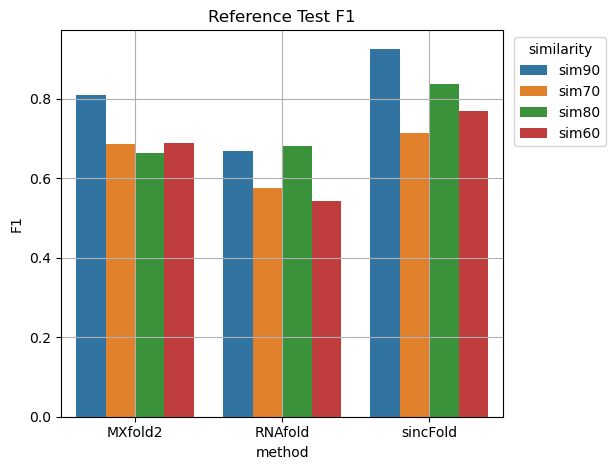

In [34]:
fig, ax = plt.subplots()

sns.barplot(data = relevant_df.loc[relevant_df.partition=="test"],
            x="method",
            y= "F1",
            hue="split", ax= ax)
ax.legend(title="similarity",bbox_to_anchor=(1.25,1),loc="upper right")
ax.set_title("Reference Test F1")
ax.grid()
fig.tight_layout()

In [35]:
results_df.loc[results_df.partition=="test"].sort_values(by=["method", "split"], ascending=False)

,split,partition,method,F1,n
8,sim90,test,sincFold,0.926532,50
29,sim80,test,sincFold,0.838090,26
17,sim70,test,sincFold,0.713864,13
46,sim60,test,sincFold,0.769344,8
37,sim50,test,sincFold,0.725766,5
7,sim90,test,RNAfold,0.669518,50
28,sim80,test,RNAfold,0.680836,26
16,sim70,test,RNAfold,0.577068,13
45,sim60,test,RNAfold,0.542552,8
36,sim50,test,RNAfold,0.462309,5


In [36]:
pivot = results_df.pivot_table(
    index=["split", "partition"],
    columns="method",
    values="F1"
)
pivot


method            MXfold2   RNAfold  sincFold
split partition                              
sim40 train      0.111111  0.091954  0.666667
sim50 test       0.597573  0.462309  0.725766
      train      0.414107  0.411200  0.693635
      valid           NaN  0.857143  0.784314
sim60 test       0.689437  0.542552  0.769344
      train      0.564585  0.517119  0.713474
      valid      0.551864  0.541264  0.665349
sim70 test       0.686133  0.577068  0.713864
      train      0.697602  0.587124  0.827118
      valid      0.615626  0.526617  0.780053
sim80 test       0.664046  0.680836  0.838090
      train      0.778169  0.601841  0.874741
      valid      0.709734  0.502111  0.844042
sim90 test       0.809503  0.669518  0.926532
      train      0.797757  0.616527  0.906763
      valid      0.797523  0.644425  0.897658

In [40]:

df_sf = pd.read_csv("../logs/ArchiveII_simfold_128/test_sincFold.csv", index_col=0) 
baseline = (
    df_sf[df_sf["epochs"] == 15]
    .set_index("similarity")["f1"]
)

In [43]:
df_test = results_df.loc[results_df.partition=="test"].sort_values(by=["method", "split"], ascending=False)[["split", "method", "F1"]].reset_index()

In [42]:
baseline

df_retrain = (
    baseline
    .rename("F1")
    .reset_index()
    .rename(columns={"similarity": "split"})
)

df_retrain["partition"] = "test"
df_retrain["method"] = "sincfold_retrain"
df_retrain["n"] = np.nan   # o 0, o el valor que quieras


In [46]:
df = pd.concat([df_test,df_retrain])

/tmp/ipykernel_145637/2389977961.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


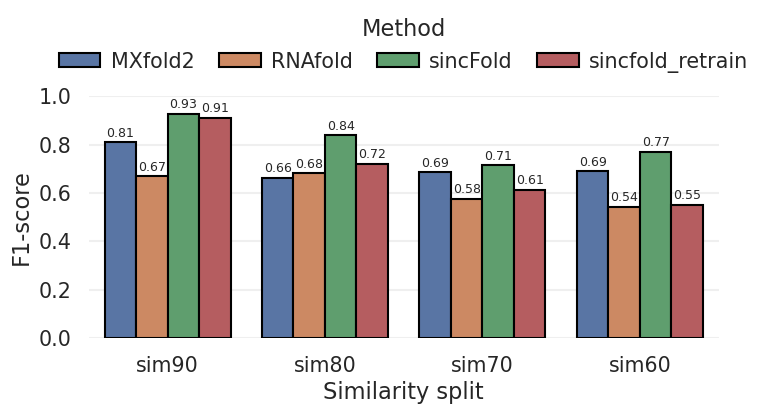

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# estilo general
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=0.9
)

plt.figure(figsize=(8, 5))

ax = sns.barplot(
    data=df.query("split != 'sim50'").sort_values(by="method"),
    x="split",
    y="F1",
    hue="method",
    errorbar=None,      # evita barras de error si no son necesarias
    edgecolor="black"
)

# límites y labels
ax.set_ylim(0, 1)
ax.set_ylabel("F1-score")
ax.set_xlabel("Similarity split")

# rotación si hiciera falta
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# leyenda prolija
ax.legend(
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.4),
    ncol=5,
    frameon=False,
    columnspacing=1.2,
    handletextpad=0.5
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=9, padding=2)

# grilla suave solo horizontal
ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", visible=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
